# Hybrid Embedding Model

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [4]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Linear Embedding Model

In [5]:
class EmbeddingModel:
    def __init__(self, input_dim, embedding_dim, learning_rate=0.001, dropout_rate=0.2):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self._build_model()
    
    def _build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(128, activation='relu')(input_layer)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        embedding_layer = Dense(self.embedding_dim, activation='relu')(x)
        x = Dropout(self.dropout_rate)(embedding_layer)
        x = Dense(64, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        output_layer = Dense(self.input_dim, activation='linear')(x)

        # Create the MLP model
        self.encoder = Model(inputs=input_layer, outputs=output_layer)
        
        # Create a separate model for extracting embeddings
        self.embedding_model = Model(inputs=input_layer, outputs=embedding_layer)
        
        # Compile the MLP model
        self.encoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
    
    def train(self, data, epochs=100, batch_size=64, patience=10):
        early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.encoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping])
    
    def get_embeddings(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            return self.embedding_model.predict(data)
    
    def summary(self):
        print("Encoder Model Summary:")
        self.encoder.summary()
        print("\nEmbedding Model Summary:")
        self.embedding_model.summary()

In [6]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [7]:
features_df

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
...,...,...,...,...,...,...,...,...,...,...,...
99995,1.000000,0,1,0,0,0,0,1,0,0.475269,0.683419
99996,0.666667,0,0,0,0,0,0,1,0,0.562420,0.861997
99997,0.666667,0,1,0,0,0,0,1,0,0.225903,0.243447
99998,0.333333,0,1,1,0,0,0,0,0,0.073531,0.058008


In [8]:
features.shape

(100000, 11)

In [9]:
# Initialize and train the autoencoder model
input_dim = features.shape[1]
embedding_dim = features.shape[1]  # Embedding dimension of 11 to make it easy to plot the resulting embeddings on a 2D scatter plot

In [10]:
embedding_model = EmbeddingModel(input_dim=input_dim, embedding_dim=embedding_dim, dropout_rate=0.2)
embedding_model.summary()

Encoder Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
 dropout_2 (Dropout)         (None, 11

In [11]:
embedding_model.train(features, epochs=100, batch_size=64, patience=10)

Epoch 1/100
1563/1563 [==============================] - 7s 3ms/step - loss: 0.0517
Epoch 2/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0275
Epoch 3/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0229
Epoch 4/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0208
Epoch 5/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0194
Epoch 6/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0186
Epoch 7/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0179
Epoch 8/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0175
Epoch 9/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0171
Epoch 10/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0168
Epoch 11/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0165
Epoch 12/100
1563/1563 [==============================] - 4s 3ms/step - lo

In [12]:
embeddings = embedding_model.get_embeddings(features)

3125/3125 [==============================] - 2s 601us/step


## PCA

In [13]:
pca = PCA()
pca.fit(embeddings)

PCA()

In [14]:
print(pca.explained_variance_ratio_)

[0.44114412 0.22636053 0.12636008 0.07006173 0.06222685 0.03224307
 0.01881258 0.01253235 0.00657406 0.00240581 0.00127881]


Number of components explaining at least 80% variance: 4


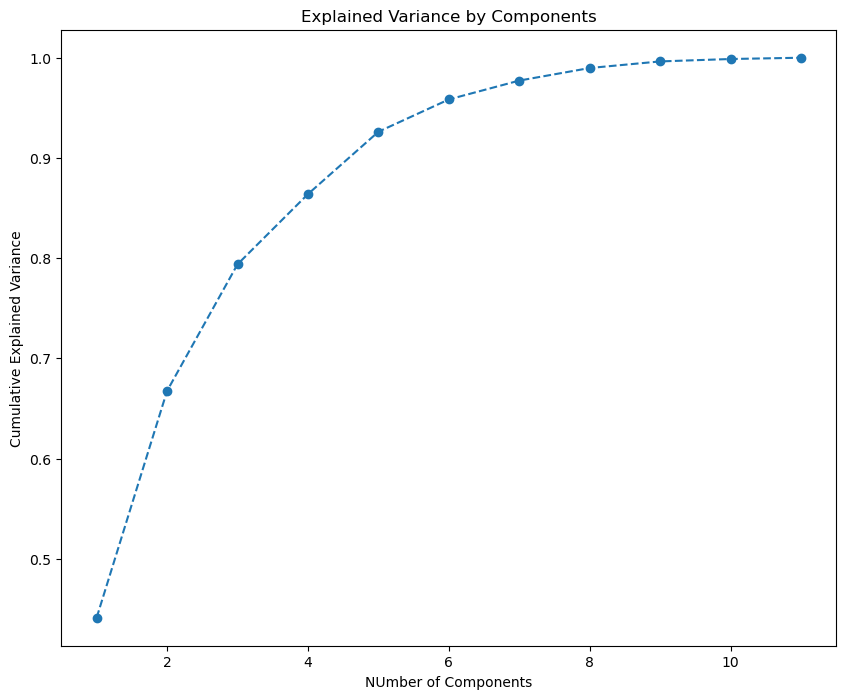

In [15]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize= (10, 8))
plt.plot(range(1,12), cumulative_explained_variance, marker = 'o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('NUmber of Components')
plt.ylabel('Cumulative Explained Variance')

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
print(f"Number of components explaining at least 80% variance: {n_components_80}")

In [16]:
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)

## Determine the number of clusters(k)

In [17]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features_pca)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


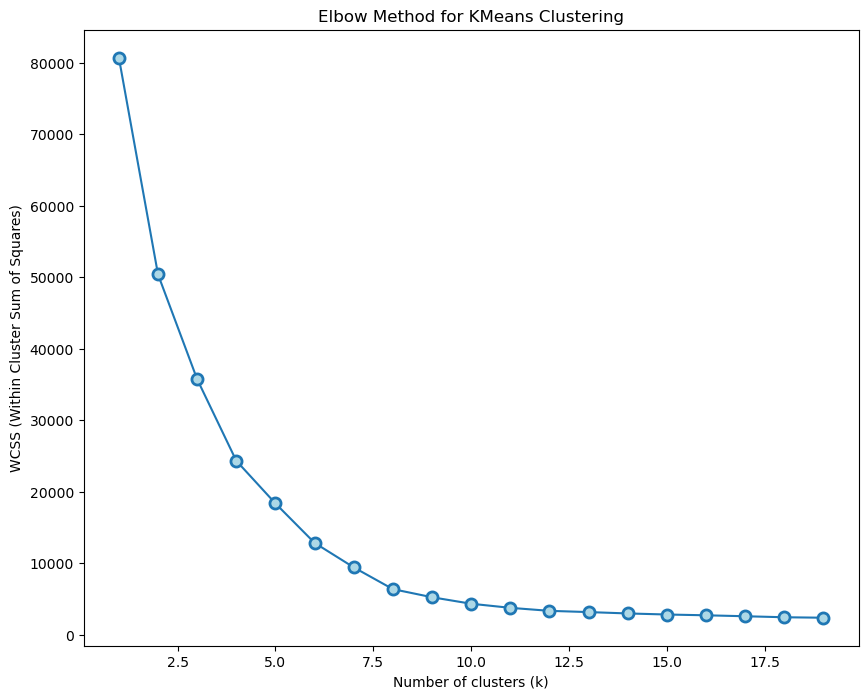

In [18]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [19]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=4, random_state=0).fit(features_pca)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(features_pca)], axis=1)
df_pca.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
df_pca['clusters'] = kmeans.labels_
df_pca['cluster_kmeans'] = kmeans.predict(features_pca)
df_latex = df_pca.groupby(['cluster_kmeans']).mean()
df_latex

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score,Component 1,Component 2,Component 3,clusters
cluster_kmeans,,,,,,,,,,,,,,,
0,0.522435,0.765411,1.0,0.128558,0.228243,0.282130,0.191501,0.0,0.169568,0.333116,0.337684,-0.258680,0.657464,-0.068118,0.0
1,0.436769,0.774892,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.563272,0.477326,0.401790,-0.688685,0.047412,1.0
2,0.618679,0.773656,0.0,0.139905,0.252873,0.266683,0.157329,0.0,0.183210,0.562612,0.457008,-0.632211,-0.293124,-0.055769,2.0
3,0.376806,0.705188,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.332411,0.343063,0.762539,0.265066,0.110904,3.0


In [20]:
df_latex.drop(columns=['Component 1', 'Component 2', 'Component 3', 'clusters'], inplace=True)
df_latex = df_latex.T

In [21]:
df_latex

cluster_kmeans,0,1,2,3
yeojohnson_revenue_in_eur_bin,0.522435,0.436769,0.618679,0.376806
is_EMEA,0.765411,0.774892,0.773656,0.705188
is_Webshop,1.000000,0.000000,0.000000,1.000000
is_industry_FinanceInsuranceRealEstate,0.128558,0.000000,0.139905,0.000000
is_industry_Manufacturing,0.228243,0.000000,0.252873,0.000000
is_industry_Other,0.282130,0.000000,0.266683,0.000000
is_industry_RetailTrade,0.191501,0.000000,0.157329,0.000000
is_industry_Services,0.000000,1.000000,0.000000,1.000000
is_industry_WholesaleTrade,0.169568,0.000000,0.183210,0.000000
license_value_score,0.333116,0.563272,0.562612,0.332411


In [22]:
latex_table = df_latex.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Average Values of each feature per Cluster",  # The caption to appear above the table in the LaTeX document
    label="tab:avg_clusters",  # A label used for referencing the table within the LaTeX document
    position="H",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="cccc",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.3f}".format  # Formats floats to two decimal places
)

print(latex_table)

\begin{table}[H]
\centering
\caption{Average Values of each feature per Cluster}
\label{tab:avg_clusters}
\begin{tabular}{cccc}
\toprule
    0 &     1 &     2 &     3 \\
\midrule
0.522 & 0.437 & 0.619 & 0.377 \\
0.765 & 0.775 & 0.774 & 0.705 \\
1.000 & 0.000 & 0.000 & 1.000 \\
0.129 & 0.000 & 0.140 & 0.000 \\
0.228 & 0.000 & 0.253 & 0.000 \\
0.282 & 0.000 & 0.267 & 0.000 \\
0.192 & 0.000 & 0.157 & 0.000 \\
0.000 & 1.000 & 0.000 & 1.000 \\
0.170 & 0.000 & 0.183 & 0.000 \\
0.333 & 0.563 & 0.563 & 0.332 \\
0.338 & 0.477 & 0.457 & 0.343 \\
\bottomrule
\end{tabular}
\end{table}



In [23]:
df_pca.cluster_kmeans.value_counts()

2    29327
0    26945
3    22014
1    21714
Name: cluster_kmeans, dtype: int64

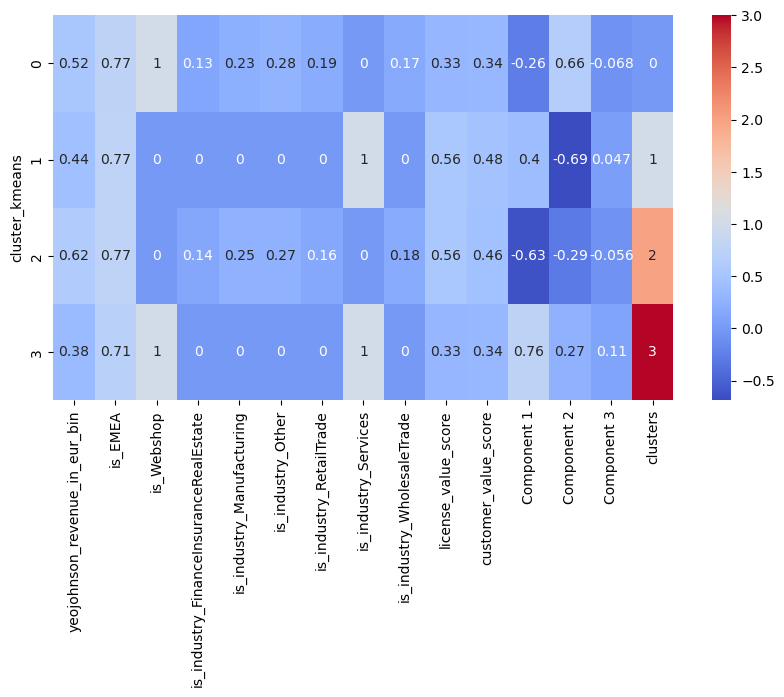

In [24]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df_pca.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [25]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", 
                    line_close=True,
                    height=800,
                    width=1200, 
                    title="AE Embedding Model 10-Feature Set Radar Chart")
fig.show()

In [26]:
clusters_df = clusters.groupby('label').size().reset_index()
clusters_df.rename(columns={'label': 'cluster', 0: 'count'}, inplace=True)
clusters_df

,cluster,count
0,0,26945
1,1,21714
2,2,29327
3,3,22014


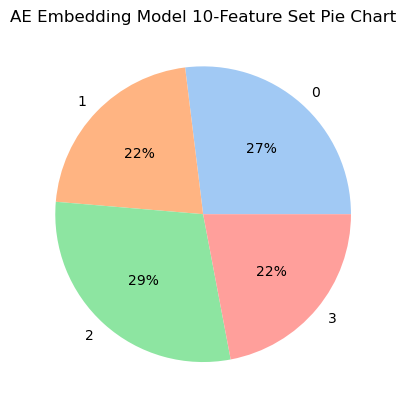

In [27]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(clusters_df['count'], labels = clusters_df['cluster'], colors = colors, autopct='%.0f%%')
plt.title('AE Embedding Model 10-Feature Set Pie Chart')
plt.show()

## Evaluation

In [28]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.226


In [29]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 1.845
